In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

plt.style.use('seaborn-poster')

### Exploración de los datos

In [4]:
df = pd.read_csv('./../data/Solar_Energy_Production.csv')
df.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258423 entries, 0 to 258422
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              258423 non-null  object 
 1   id                258423 non-null  int64  
 2   address           258423 non-null  object 
 3   date              258423 non-null  object 
 4   kWh               258423 non-null  float64
 5   public_url        258423 non-null  object 
 6   installationDate  258423 non-null  object 
 7   uid               258423 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 15.8+ MB


#### Sitios con instalaciones de paneles solares

In [6]:
df['name'].unique()

array(['Calgary Fire Hall Headquarters', 'Whitehorn Multi-Service Centre',
       'Southland Leisure Centre',
       'Hillhurst Sunnyside Community Association',
       'Glenmore Water Treatment Plant',
       'City of Calgary North Corporate Warehouse',
       'Richmond - Knob Hill Community Hall', 'Manchester Building M',
       'CFD Firehall #7', 'Telus Spark', 'Bearspaw Water Treatment Plant'],
      dtype=object)

#### Fecha en la que se instaló cada proyecto

In [7]:
site_install = df.groupby('name')['installationDate'].unique()
site_install = pd.DataFrame(site_install).sort_values(by='installationDate')

site_install

,installationDate
name,
Southland Leisure Centre,[2015/09/01]
Hillhurst Sunnyside Community Association,[2016/09/25]
Calgary Fire Hall Headquarters,[2016/11/07]
Richmond - Knob Hill Community Hall,[2016/11/21]
Whitehorn Multi-Service Centre,[2016/12/13]
City of Calgary North Corporate Warehouse,[2016/12/21]
Glenmore Water Treatment Plant,[2017/01/11]
CFD Firehall #7,[2017/09/13]
Manchester Building M,[2017/10/23]


#### Producción total de energía solar desde septiembre 2015 hasta marzo 2023 

In [8]:
# solar power production per site
counts = df.groupby('name')['kWh'].sum()
site_totals = pd.DataFrame(counts).sort_values(by='kWh', ascending=False)

site_totals

,kWh
name,
Bearspaw Water Treatment Plant,3082637.596
Whitehorn Multi-Service Centre,2558802.505
Glenmore Water Treatment Plant,1551177.716
Southland Leisure Centre,1147493.626
City of Calgary North Corporate Warehouse,768964.640
Hillhurst Sunnyside Community Association,186441.264
Manchester Building M,183243.243
CFD Firehall #7,170080.887
Calgary Fire Hall Headquarters,110211.611


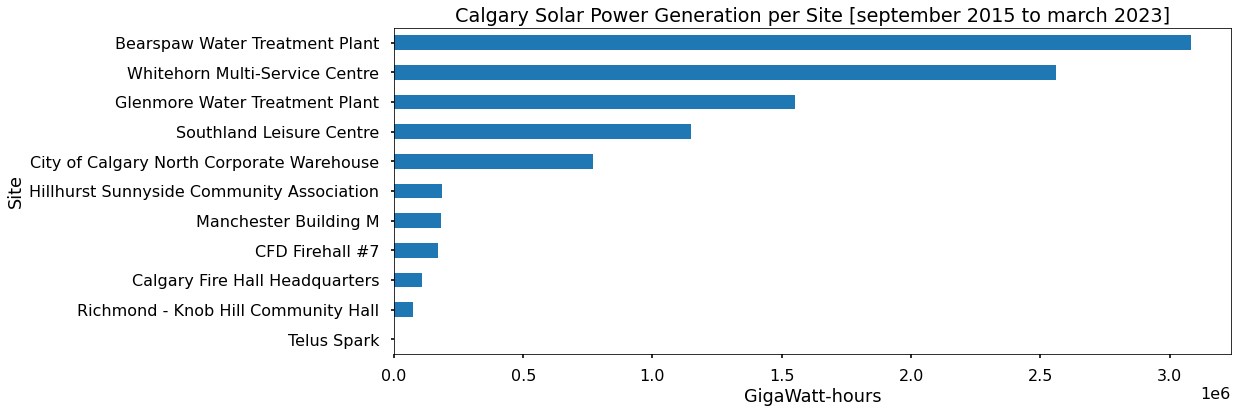

In [9]:
site_totals = site_totals.sort_values(by='kWh', ascending=True)

site_totals.plot(figsize=(15, 6), kind='barh', legend=False)
plt.title('Calgary Solar Power Generation per Site [september 2015 to march 2023]')
plt.xlabel('GigaWatt-hours')
plt.ylabel('Site')

plt.show()

#### Dataframe para análisis de series de tiempo

In [10]:
df['date'] = pd.to_datetime(df['date']) 

df_pw = df.drop(columns= ['name', 'id', 'address', 'public_url', 'installationDate', 'uid'])
df_pw = df_pw.set_index('date')

df_pw.head() 

,kWh
date,
2017-09-11 08:00:00,1.130
2017-09-11 09:00:00,2.340
2017-09-11 10:00:00,3.656
2017-09-11 11:00:00,4.577
2017-09-11 12:00:00,6.506


In [11]:
count_date = df_pw.groupby('date')['kWh'].sum()

pw_clean = pd.DataFrame(count_date)
pw_clean.head()

,kWh
date,
2015-09-01 14:30:00,27.805
2015-09-01 15:30:00,30.559
2015-09-01 16:30:00,23.613
2015-09-01 17:30:00,15.257
2015-09-01 18:30:00,7.896


In [12]:
pw_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36192 entries, 2015-09-01 14:30:00 to 2023-03-16 19:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     36192 non-null  float64
dtypes: float64(1)
memory usage: 565.5 KB


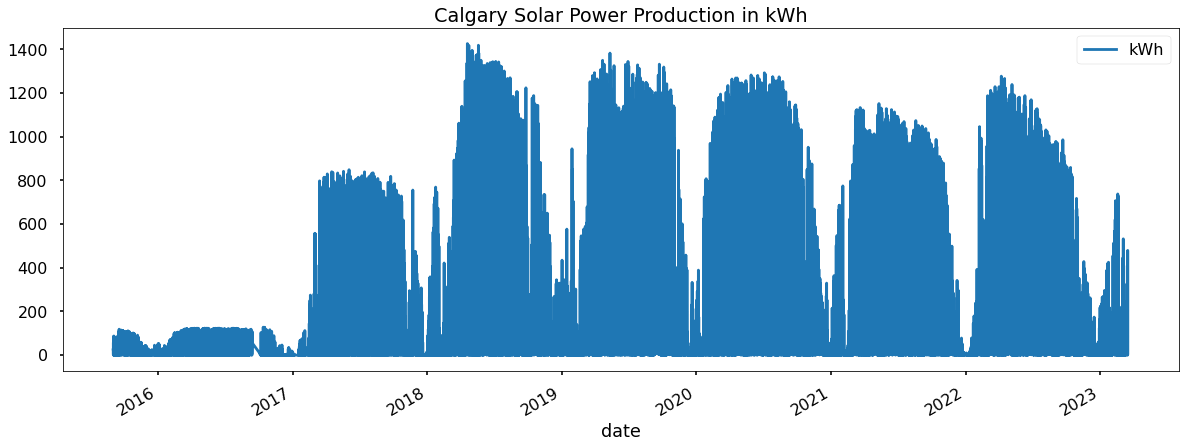

In [13]:
plt.style.use('seaborn-poster')
pw_clean.plot(style='-',
        figsize=(20, 7),
        title='Calgary Solar Power Production in kWh')
plt.show()

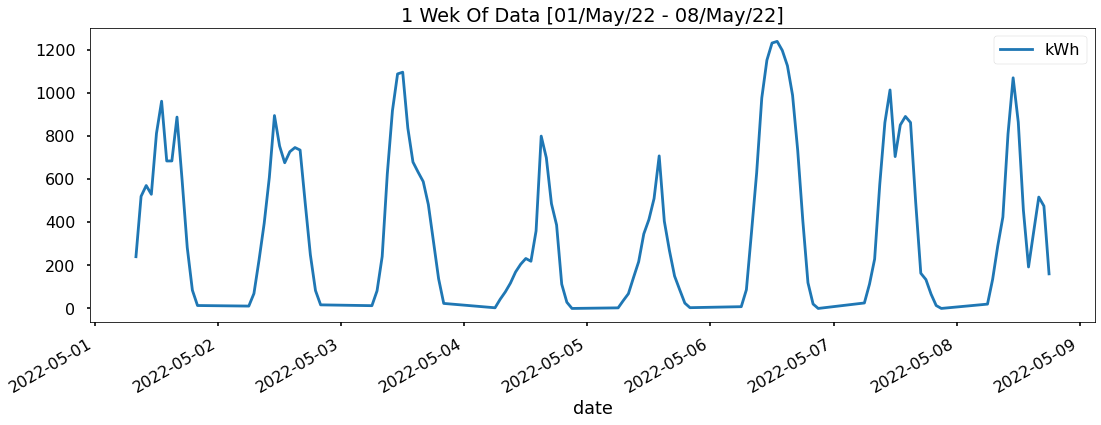

In [73]:
pw_clean.loc[(pw_clean.index > '05-01-2022 07:00:00') & (pw_clean.index < '05-08-2022 19:00:00')] \
    .plot(style='-', figsize=(18, 6), title='1 Wek Of Data [01/May/22 - 08/May/22]')
plt.show()

### Set de Entrenamiento / Prueba

**Por simplicidad, removemos los datos anteriores a 2017. Observamos que a partir de 2017 se finalizó la instalación de todos los sitios.**  

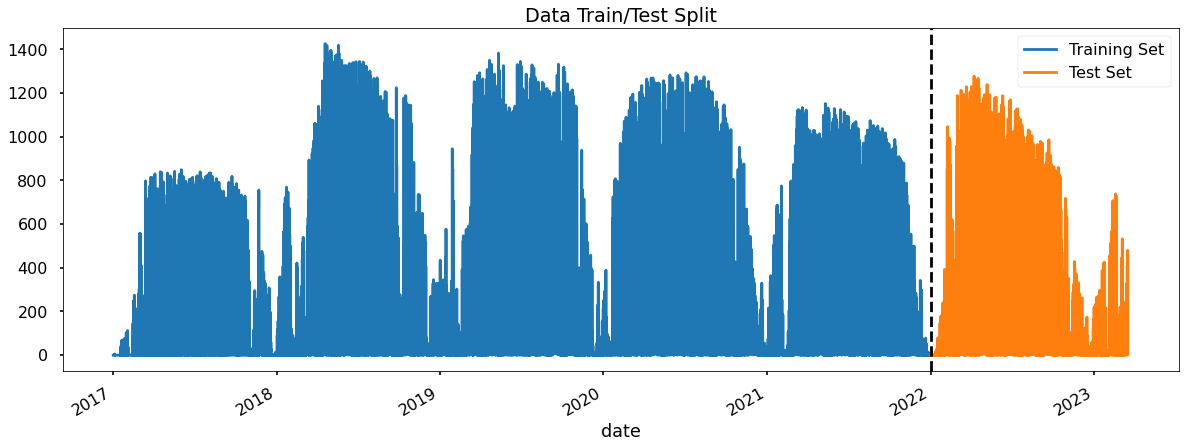

In [15]:
# remove data prior to 2017
pw_clean = pw_clean.loc[pw_clean.index >= '01-01-2017']

# test/train split
train = pw_clean.loc[pw_clean.index < '01-01-2022']
test = pw_clean.loc[pw_clean.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(20, 7))
train.plot(ax=ax, style='-', label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, style='-', label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Creación de Atributos (Feature Engineering)

**Atributos basados en el índice de la serie de tiempo**

In [17]:
#train set
train = train.copy()
train['hour'] = train.index.hour
train['dayofweek'] = train.index.dayofweek
train['weekofyear'] = train.index.isocalendar().week
train['month'] = train.index.month
train['quarter'] = train.index.quarter
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear 

#test set
test = test.copy()
test['hour'] = test.index.hour
test['dayofweek'] = test.index.dayofweek
test['weekofyear'] = test.index.isocalendar().week
test['month'] = test.index.month
test['quarter'] = test.index.quarter
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear 

#### Visualizacion de attributos contra target

**kWh por hora del día**

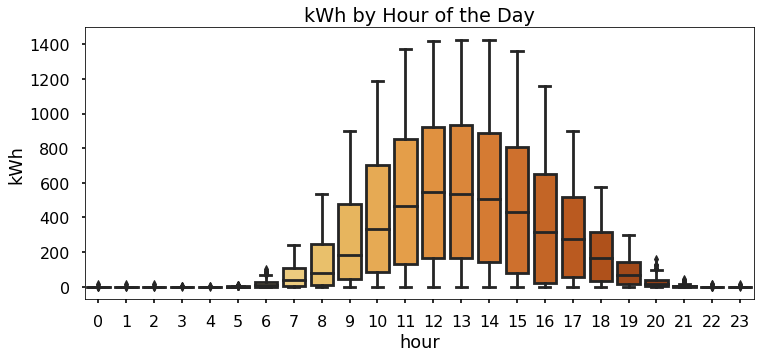

In [70]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=train, x='hour', y='kWh', palette='YlOrBr')
ax.set_title('kWh by Hour of the Day')
plt.show()

**kWh por Mes**

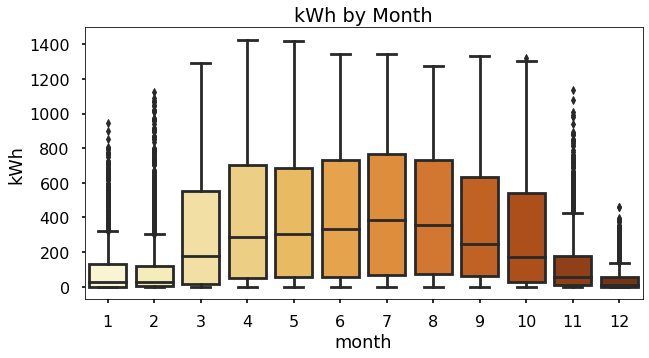

In [71]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=train, x='month', y='kWh', palette='YlOrBr')
ax.set_title('kWh by Month')
plt.show()

**Atributos "Lag" (Lag attributes)**